<a href="https://www.kaggle.com/code/birendra41/tea-leaves-pest-detection-transfer-learning?scriptVersionId=251465871" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🐛 Tea Leaves Pest Classifier – Built From Scratch

This notebook documents my complete pipeline for building an image classifier to detect and identify 10 types of insect pests commonly found on tea leaves.  
I not only trained the model using transfer learning with VGG16, but also created and structured the dataset myself from the ground up.

## 📦 Custom Dataset Summary

The dataset was manually compiled and organized by me. It contains high-quality images across 10 pest classes. For consistency and model readiness, all images are resized to **150x150 pixels**.

**Directory Structure**:

```
pest/
├── train/
│   ├── borer/               ← 60 images × 5 copies
│   ├── caterpillar/
│   ├── ...
├── test/
│   ├── borer/               ← 60 unique images
│   ├── caterpillar/
│   ├── ...
```

**Details**:
- **Classes**: borer, caterpillar, grub, leafworm, mite, nematode, tea-aphid, tea-mosquito-bug, termite, thrip  
- **Train Set**: 60 images per class × 5 copies = 300 images per class  
- **Test Set**: 60 unique images per class (no duplication)  
- All images are labeled and stored in class-specific subfolders

## 🧠 Model Overview

- **Architecture**: VGG-16 (pretrained on ImageNet, custom top layers for classification)
- **Input Size**: 150×150×3 RGB
- **Output**: 10 softmax probability scores (one per class)
- **Loss**: `categorical_crossentropy`
- **Optimizer**: Adam
- **Metrics**: Accuracy, AUC

## 🔁 Pipeline Walkthrough

### 1. 📂 Data Loading
- Load and preprocess images from the `pest/train` and `pest/test` directories.
- Apply normalization (scale pixel values to [0, 1]) and one-hot encode the labels.

### 2. 🏗️ Model Construction
- Use the VGG-16 backbone with frozen convolutional layers
- Add custom dense layers for fine-tuning the classification head

### 3. 🧪 Training and Evaluation
- Train the model on the training set and validate using a portion of it
- Evaluate using the separate 60-image-per-class test set
- Save the trained model to `vgg16_classifier.h5` for future use

### 4. 🔍 Results Visualization
- Display random test predictions with true vs predicted labels
- Use red/green color coding to indicate misclassifications
- Show a bar graph of class probabilities

### 5. 🌐 URL Prediction Functionality
- Load any pest image from the internet by URL
- Show both the raw image and prediction confidence bar plot

## 🛠️ Tools & Technologies Used

- **TensorFlow / Keras** – Model building and training  
- **Matplotlib** – Visualization  
- **NumPy** – Data manipulation  
- **PIL + Requests** – Online image loading and processing

## ✅ Goal

Build a minimal yet effective pest classifier pipeline entirely from scratch—  
from dataset creation and structuring to training, evaluation, and visualization.  
This serves as both a personal learning project and a useful agricultural AI tool.

*Author: [Birendra Nath Nandi](https://www.linkedin.com/in/birendra-nath-nandi/)*  
*Date: July 2025*  
*License: Apache 2.0*

# 📂 1. Environment Setup & Library Imports

In [1]:
# === System & Utilities ===
import os
import sys
import warnings
from io import BytesIO

# === Data Handling ===
import numpy as np
import pandas as pd

# === Progress Visualization ===
from tqdm import tqdm
from tqdm.keras import TqdmCallback

# === Plotting & Visualization ===
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns

# === Image Handling ===
import cv2
from PIL import Image
import requests

# === Machine Learning (Scikit-learn) ===
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)

# === TensorFlow & Keras ===
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TF logs
stderr = sys.stderr
sys.stderr = open(os.devnull, 'w')       # Temporarily suppress stderr

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import AUC
from keras.utils import to_categorical

# sys.stderr = stderr  # Restore stderr

# === Other ===
import random

# === Warnings ===
warnings.filterwarnings('ignore')

2025-07-20 07:59:03.389498: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752998343.565498      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752998343.616223      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### 🧠 Environment Setup and Library Imports

This section sets up the environment and imports the necessary libraries for machine learning, deep learning, data manipulation, and visualization.

### ✅ General-Purpose Libraries
- `os`: Used for operating system-level interactions (like suppressing TensorFlow logs).
- `sys`: Used to redirect error output temporarily.
- `numpy`: Efficient numerical operations and matrix handling.
- `pandas`: Data loading and preprocessing with DataFrames.
- `tqdm`: Provides progress bars for loops and model training.

### 🤖 Machine Learning Utilities (Scikit-learn)
- `shuffle`: Randomizes dataset order.
- `train_test_split`: Splits data into training and testing sets.
- `classification_report`, `confusion_matrix`, `ConfusionMatrixDisplay`: For classification evaluation.
- `roc_curve`, `auc`: Used to calculate and visualize Receiver Operating Characteristic (ROC) curves and Area Under Curve (AUC) scores.

### ⚙️ TensorFlow Configuration
- Suppresses TensorFlow backend logs using `os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'`.
- Redirects `stderr` temporarily to hide backend initialization warnings before importing TensorFlow.

### 🧬 TensorFlow & Keras (Deep Learning Framework)
- `tensorflow`, `keras`: The core deep learning libraries used for model creation, training, and evaluation.
- `EarlyStopping`: Stops training early if validation loss does not improve.
- `TqdmCallback`: Adds a progress bar to the Keras training loop.
- `to_categorical`: Converts integer class labels to one-hot encoded vectors.
- `VGG16`: Pre-trained CNN used as the base model for transfer learning.
- `Dense`, `Flatten`, `Dropout`: Core layers for building the custom classifier.
- `Model`: Combines pre-trained base with custom classifier layers.
- `Adam`: Optimizer for updating weights efficiently.
- `CategoricalCrossentropy`: Loss function suited for multi-class classification tasks.
- `AUC`: A metric to monitor classifier performance over training epochs.

### 📊 Visualization and Evaluation
- `seaborn`: Enhances plot aesthetics for data visualizations.
- `get_cmap`: Loads colormap schemes from Matplotlib for customized plots.
- `matplotlib.pyplot`: General-purpose plotting library.

### 🖼️ Image Processing
- `cv2`: OpenCV library for image loading, resizing, and preprocessing.
- `PIL.Image`: Alternative image manipulation tool from the Pillow library.

### ⚠️ Warning Suppression
- `warnings.filterwarnings('ignore')`: Silences all runtime warnings to declutter output.

# 🗂️ 2. Dataset Directory Setup & Class Discovery

In [2]:
# Set paths to training and testing directories
train_ds = '/kaggle/input/tea-leaves-pest-dataset/TeaLeavesPest-Dataset/pest/train'
test_ds = '/kaggle/input/tea-leaves-pest-dataset/TeaLeavesPest-Dataset/pest/test'

# Get list of class folder names in the training directory
img = [name for name in os.listdir(train_ds) if os.path.isdir(os.path.join(train_ds, name))]
img  # Display the list of class names

# List all files/folders in the root of the Kaggle input directory
print(os.listdir("/kaggle/input/"))

# List all files/folders inside the pest dataset directory
print(os.listdir("/kaggle/input/tea-leaves-pest-dataset/TeaLeavesPest-Dataset/pest"))

['tea-leaves-pest-dataset']
['test', 'train']


### 📁 Dataset Directory Setup & Class Discovery

This section sets the path to the training and testing datasets, checks the available classes, and confirms directory structure.

- `train_ds` and `test_ds` define the absolute paths to the training and test image directories within the Kaggle dataset.
- `os.listdir()` lists all the folders (i.e., class names) inside the training directory.
- The list comprehension filters only directories to identify the class folders (each pest type).
- The final two `print()` calls show the contents of the root input directory and the specific pest directory to verify successful loading and structure.

This step ensures the dataset is structured correctly and helps dynamically extract class names from folder names.

# 🧾 3. Dataset Structure Detection & Image Loading

In [3]:
# Define the dataset root directory
dataset_root = "/kaggle/input/tea-leaves-pest-dataset/TeaLeavesPest-Dataset"

# List all subdirectories inside the root
subdirs = os.listdir(dataset_root)
print("Dataset structure:", subdirs)

# If 'pest' is one of the subdirectories, update the dataset root path
if "pest" in subdirs:
    dataset_root = os.path.join(dataset_root, "pest")

# Define the folders to process (train and test)
data_dirs = ["train", "test"]

# Automatically detect label/class names from the train folder
labels = os.listdir(os.path.join(dataset_root, "train"))

# Initialize lists to hold image data and corresponding labels
image_data, label_data = [], []
image_size = 150  # Target size to resize all images

# Loop through both train and test directories
for data_dir in data_dirs:
    print(f"📂 Processing '{data_dir}' directory...")
    
    # Loop through each label/class
    for label_idx, label in enumerate(labels):
        data_path = os.path.join(dataset_root, data_dir, label)

        # If the class directory is missing, skip it
        if not os.path.exists(data_path):
            print(f"⚠️ Warning: Missing directory - {data_path}")
            continue

        # Loop through each image file in the class directory
        for img_file in os.listdir(data_path):
            img_path = os.path.join(data_path, img_file)
            image = cv2.imread(img_path)  # Load image using OpenCV

            # Skip corrupted or unreadable images
            if image is None:
                print(f"❌ Skipping corrupted file: {img_path}")
                continue

            image = cv2.resize(image, (image_size, image_size))  # Resize image
            image_data.append(image)  # Add image to list
            label_data.append(label_idx)  # Add corresponding label index

# Print total images loaded
print(f"\n✅ Data processing complete! Loaded {len(image_data)} images.")

Dataset structure: ['pest']
📂 Processing 'train' directory...
📂 Processing 'test' directory...

✅ Data processing complete! Loaded 3600 images.


### 🧾 Dataset Structure Detection & Image Loading

This section dynamically verifies the dataset structure and loads all images into memory, along with their corresponding class labels.

### 🔍 Dataset Root Path Detection
- `dataset_root`: Points to the base dataset directory.
- The code lists subdirectories inside it to detect if a `"pest"` folder is present.
- If `"pest"` exists, it updates `dataset_root` to point one level deeper (ensuring flexibility if directory structure changes).

### 📦 Training & Testing Setup
- `data_dirs`: Defines the folders for training and testing data.
- `labels`: Automatically detects class names by listing subfolders inside the `train` directory.

### 🖼️ Image Loading Loop
- Iterates over both `train/` and `test/` directories.
- For each class folder (`label`), it constructs a full image path and loads each image.
- Images are resized to 150x150 for uniform input dimensions.
- Images are appended to `image_data`, and their corresponding numeric label index to `label_data`.

### ⚠️ Robustness Features
- Checks for missing directories and prints a warning.
- Skips corrupted images (i.e., unreadable with OpenCV) and logs their paths.

### ✅ Output
At the end, it confirms how many valid images were successfully loaded into memory.

This approach allows dynamic, error-tolerant loading of a multi-class image dataset with automatic label generation.

# 🧪 4. Data Shuffling, Normalization & Splitting

In [4]:
# Shuffle the image and label data together for randomness
image_data, label_data = shuffle(image_data, label_data, random_state=42)

# Normalize image pixel values to [0, 1] and convert to NumPy array
image_data = np.array(image_data, dtype=np.float32) / 255.0

# Convert labels to NumPy array (integers)
label_data = np.array(label_data, dtype=np.int32)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(
    image_data, label_data, test_size=0.2, random_state=42
)

# Print the number of samples in training and testing sets
print(f"✅ Data ready for training! Training samples: {len(X_train)}, Test samples: {len(X_test)}")

✅ Data ready for training! Training samples: 2880, Test samples: 720


### 🧪 Data Shuffling, Normalization & Splitting

This step prepares the image and label data for training by applying essential preprocessing operations.

- **Shuffling the dataset:**  
  Uses `sklearn.utils.shuffle` to randomly reorder the dataset. This prevents the model from learning any unintended sequence-based patterns.

- **Normalization:**  
  Converts `image_data` to a NumPy array of type `float32` and scales pixel values to the range `[0, 1]` by dividing by `255.0`. This helps the model converge faster during training.

- **Label encoding:**  
  Converts `label_data` to a NumPy array of integers. These numeric class indices will be used for training the model.

- **Train-test split:**  
  Splits the dataset into training and testing subsets using an 80-20 ratio.
  - `X_train`, `Y_train`: Used to train the model.
  - `X_test`, `Y_test`: Held out for evaluating the model's performance on unseen data.

- **Output summary:**  
  Prints the number of training and test samples to confirm that the split was successful.

# 📊 5. Class Distribution Visualization

nematode: 300 images
tea-mosquito-bug: 300 images
caterpillar: 300 images
leafworm: 300 images
grub: 300 images
borer: 300 images
mite: 300 images
thrip: 300 images
tea-aphid: 300 images
termite: 300 images
Total images are 3000


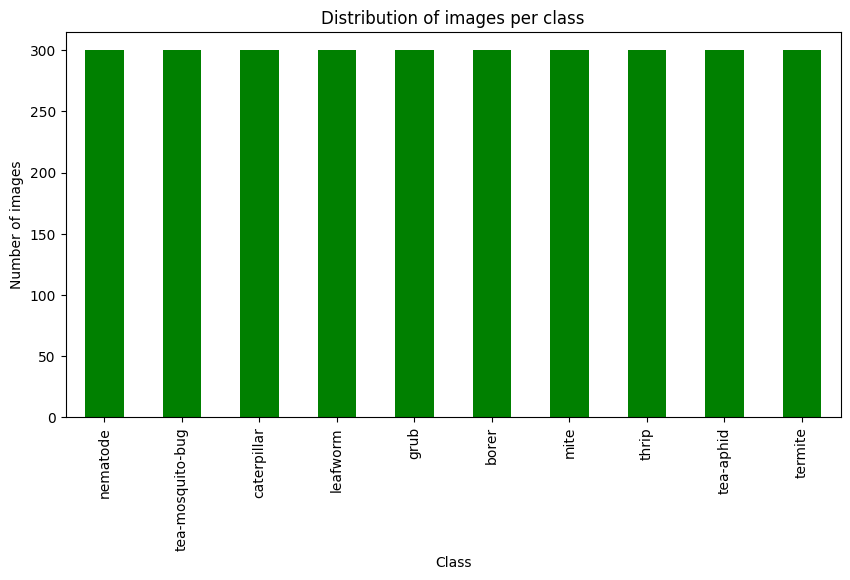

In [5]:
# Get the list of class labels from the training directory
classes = os.listdir(train_ds)

# Count the number of images in each class folder
image_counts = {cls: len(os.listdir(os.path.join(train_ds, cls))) for cls in classes}

# Print the number of images per class
for cls, count in image_counts.items():
    print(f"{cls}: {count} images")

# Calculate and print the total number of images across all classes
total = sum(image_counts.values())
print(f"Total images are {total}")

# Plot a bar chart showing the number of images per class
plt.figure(figsize=(10, 5))
pd.Series(image_counts).plot(kind='bar', color='g')
plt.title('Distribution of images per class')
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.show()

### 📊 Class Distribution Visualization

This section inspects and visualizes the number of images available in each class within the training dataset.

- **Class discovery:**  
  Uses `os.listdir(train_ds)` to list all the class folders in the training directory. Each folder represents a unique class label.

- **Counting images per class:**  
  Iterates through each class folder and counts how many image files it contains using `os.listdir()`. The result is stored in a dictionary `image_counts`.

- **Summary statistics:**  
  Prints the number of images per class and the total number of images in the training set.

- **Visualization:**  
  - Converts the class-wise image count dictionary into a `pandas.Series`.
  - Plots a green-colored bar chart using `matplotlib` to visualize how balanced or imbalanced the dataset is across classes.
  - Labels the plot with a title, x-axis, and y-axis for clarity.

This visualization is helpful in identifying whether certain classes are underrepresented, which could affect model performance and may require class balancing techniques.

# 🖼️ 6. Visual Sample of Each Class

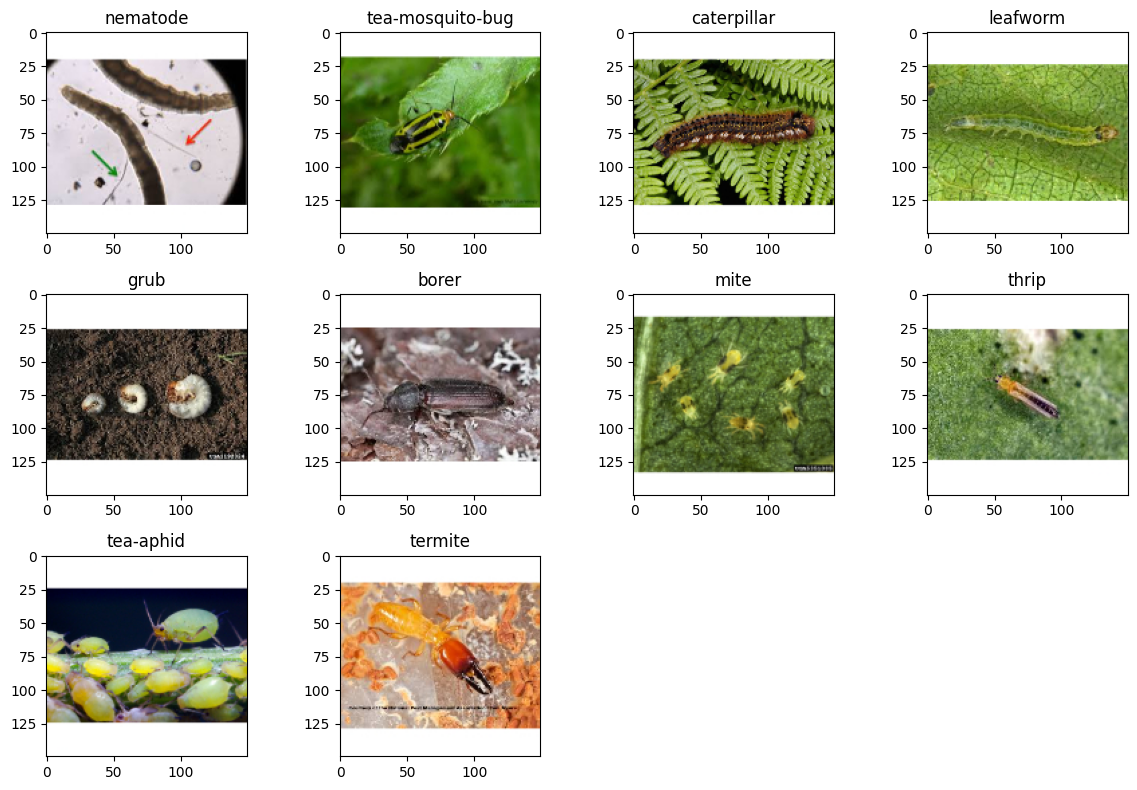

In [6]:
# Create a new figure for plotting sample images from each class
plt.figure(figsize=(12, 8))

# Loop through each class and display one sample image
for i, cls in enumerate(classes):
    cls_path = os.path.join(train_ds, cls)  # Path to class folder
    img_path = os.path.join(cls_path, os.listdir(cls_path)[0])  # Get first image file
    img = Image.open(img_path)  # Open the image
    
    plt.subplot(3, 4, i + 1)  # Create subplot (adjust rows/cols if more/fewer classes)
    plt.imshow(img)  # Show the image
    plt.title(cls)  # Set title as class name

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()  # Display the plot

### 🖼️ Visual Sample of Each Class

This section provides a visual overview by displaying one sample image from each class in the dataset.

- **Plot layout:**  
  Initializes a figure of size `12x8` and prepares a 3x4 grid (up to 12 classes supported visually).

- **Image selection:**  
  For each class:
  - Constructs the path to the class directory.
  - Selects the first image file found in the directory.
  - Opens the image using PIL (`Image.open()`).

- **Subplot rendering:**  
  Displays each image in a subplot with its corresponding class name as the title.

- **Layout adjustment:**  
  Uses `plt.tight_layout()` to prevent label or image overlap.

This helps quickly verify that:
- Images are properly loaded and readable.
- Class folders contain valid image samples.
- There's a general idea of how each pest class visually appears.

Useful for both debugging and exploratory analysis.

# 🧾 7. One-Hot Encoding of Labels

In [7]:
# Ensure training and testing labels are NumPy arrays of integer type
Y_train = np.array(Y_train, dtype=np.int32)
Y_test = np.array(Y_test, dtype=np.int32)

# Convert integer labels to one-hot encoded vectors
Y_train = to_categorical(Y_train, num_classes=len(labels))
Y_test = to_categorical(Y_test, num_classes=len(labels))

# Confirm conversion and show shape of one-hot encoded labels
print(f"✅ Labels converted to one-hot encoding. Shape: {Y_train.shape}")

✅ Labels converted to one-hot encoding. Shape: (2880, 10)


### 🧾 One-Hot Encoding of Labels

This step prepares the class labels for training by converting them into a one-hot encoded format, which is required for multi-class classification.

- **Conversion to NumPy arrays:**  
  `Y_train` and `Y_test` are first explicitly cast to 32-bit integers to ensure compatibility with Keras utilities.

- **One-hot encoding:**  
  `to_categorical()` transforms the integer labels into one-hot vectors.  
  For example:  
  - Label `2` in a 5-class problem becomes `[0, 0, 1, 0, 0]`.

- **Shape check:**  
  The resulting shape of `Y_train` is printed to confirm the conversion was successful.

This encoding is essential because the model’s output layer will produce probabilities across multiple classes, and one-hot labels provide the correct format for computing categorical loss.

# 🧠 8. VGG16 Model Construction with Transfer Learning

In [8]:
# Load pre-trained VGG16 model without the top classification layer
vgg = VGG16(input_shape=(150, 150, 3), weights='imagenet', include_top=False)

# Freeze all layers to retain pretrained weights during initial training
for layer in vgg.layers:
    layer.trainable = False  

# Flatten the output of VGG16 for the custom classifier
x = Flatten()(vgg.output)

# Add fully connected dense layers with ReLU activation
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Another dropout layer

# Output layer with softmax activation for multi-class classification
prediction = Dense(len(labels), activation='softmax')(x)  # Number of output neurons = number of classes

# Create the final model combining base VGG16 and custom classifier
modelvgg = Model(inputs=vgg.input, outputs=prediction)

# Display model architecture summary
modelvgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,57

 Total params: 19,043,402 (72.64 MB)

 Trainable params: 4,328,714 (16.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### 🧠 VGG16 Model Construction with Transfer Learning

This block constructs a convolutional neural network using the pre-trained **VGG16** model from Keras as a base, then customizes the top layers for multi-class classification.

- **Base model setup:**  
  - `VGG16` is loaded with pre-trained `ImageNet` weights.  
  - `include_top=False` excludes the original fully-connected layers to allow custom classification layers.
  - `input_shape=(150,150,3)` matches the shape of the preprocessed images.

- **Freezing base layers:**  
  All layers in the pre-trained VGG16 model are set to `trainable=False` to preserve learned features and reduce training time.

- **Custom top layers added:**  
  - `Flatten`: Converts convolutional feature maps into a 1D vector.
  - `Dense(512, relu) → Dropout(0.5)`: Learns high-level patterns while regularizing via dropout.
  - `Dense(256, relu) → Dropout(0.5)`: Adds further abstraction and dropout.
  - `Dense(len(labels), softmax)`: Final classification layer with dynamic output units matching the number of classes.

- **Model finalization:**  
  Combines VGG16 input and new output layers using Keras `Model()`.  
  `modelvgg.summary()` displays the architecture, including trainable and non-trainable parameters.

This approach uses **transfer learning** to leverage powerful pre-trained features while customizing only the top for the specific task of pest classification.

# ⚙️ 9. Model Compilation & Early Stopping Configuration

In [9]:
# Compile the model with Adam optimizer, categorical crossentropy loss, and evaluation metrics
modelvgg.compile(
    optimizer=Adam(learning_rate=0.0001),  # Low learning rate for fine-tuning
    loss=CategoricalCrossentropy(),       # Suitable for multi-class classification
    metrics=['accuracy', AUC(name='auc')] # Track both accuracy and AUC during training
)

# Define early stopping callback to prevent overfitting
callback = EarlyStopping(
    monitor='val_loss',       # Monitor validation loss
    patience=8,               # Stop if no improvement after 8 epochs
    restore_best_weights=True,  # Restore model to best epoch
    verbose=1                 # Print callback messages
)

# Confirm model compilation
print("✅ Model compiled successfully!")

✅ Model compiled successfully!


### ⚙️ Model Compilation & Early Stopping Configuration

This section compiles the VGG16-based model and sets up an early stopping mechanism to optimize training.

### 🛠️ Model Compilation
- **Optimizer:**  
  Uses the `Adam` optimizer with a small learning rate (`0.0001`) for stable and gradual convergence.
  
- **Loss Function:**  
  `CategoricalCrossentropy` is selected, which is appropriate for multi-class classification with one-hot encoded labels.

- **Metrics:**  
  - `'accuracy'`: Tracks the proportion of correctly classified samples.  
  - `AUC`: Area Under the ROC Curve, a more nuanced performance metric, especially helpful in imbalanced datasets.

### ⏹️ EarlyStopping Callback
- **Purpose:** Stops training early when the validation loss stops improving.
- **Parameters:**
  - `monitor='val_loss'`: Observes validation loss during training.
  - `patience=8`: Allows 8 epochs of no improvement before stopping.
  - `restore_best_weights=True`: Reloads the model weights from the epoch with the best validation loss.
  - `verbose=1`: Enables log output when early stopping is triggered.

### ✅ Summary
Once compiled, the model is ready for training with smart regularization and stability controls in place.

# 🚀 10. Model Training with Progress Visualization

In [10]:
# Suppress TensorFlow INFO and WARNING logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Train the model using training data, with validation on test data
history = modelvgg.fit(
    X_train, Y_train,                     # Training data and labels
    epochs=50,                            # Maximum number of training epochs
    batch_size=32,                        # Number of samples per training batch
    validation_data=(X_test, Y_test),     # Validation data and labels
    callbacks=[callback, TqdmCallback(verbose=1)],  # EarlyStopping + TQDM progress bar
    verbose=0  # Silence default output so TQDM can display progress
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 50.


### 🧠 Model Training with Progress Bar

This section handles the actual training of the model using the preprocessed dataset and the compiled VGG16-based architecture.

### 🔇 Log Suppression
```python
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
```

* Suppresses TensorFlow INFO and WARNING logs to reduce clutter in output. Keeps the notebook clean and focused.

### 🏋️ Model Training

```python
history = modelvgg.fit(...)
```

* **Inputs:**

  * `X_train`, `Y_train`: Training data and corresponding labels.
  * `X_test`, `Y_test`: Validation data for evaluating the model during training.
* **Hyperparameters:**

  * `epochs=50`: The model is allowed to train up to 50 epochs unless stopped early by the callback.
  * `batch_size=32`: Processes 32 samples at a time before updating the model weights.
* **Callbacks:**

  * `callback`: EarlyStopping logic configured earlier to halt training when no improvement is seen.
  * `TqdmCallback`: Integrates a progress bar with epoch training for visual feedback.
* **Verbose Mode:**

  * `verbose=0` is required for `TqdmCallback` to control the display of training progress.

### ✅ Summary

The model will train for up to 50 epochs, stopping early if validation loss stops improving. Training progress will be displayed neatly using `tqdm`.

# 🧪 11. Training Metrics Visualization

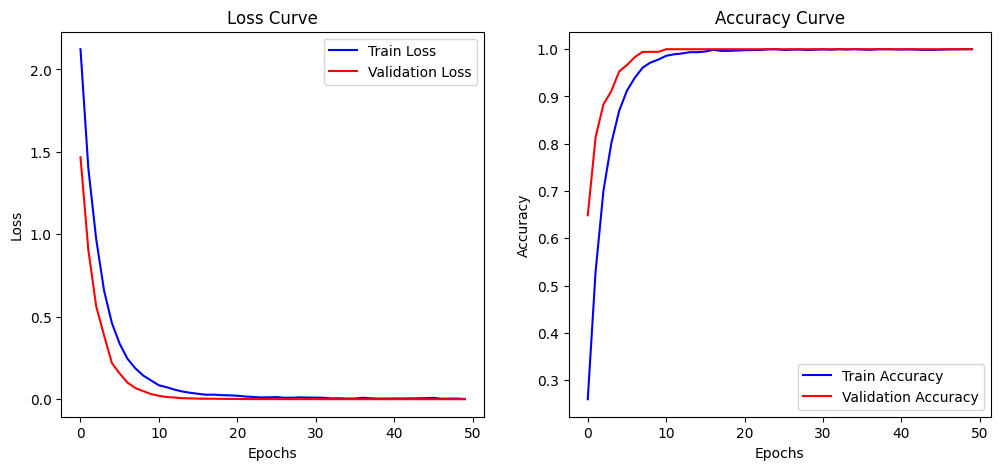

In [11]:
# Extract loss and accuracy values from training history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a figure to plot both loss and accuracy curves
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(loss, label='Train Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Train Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

# Display the plots
plt.show()

### 📊 Training Metrics Visualization

After training the model, it's essential to evaluate how well it performed across epochs. This visualization helps in understanding both **training dynamics** and potential **overfitting**.

### 📉 Plotting Training & Validation Loss
```python
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
```

* **Train Loss** indicates how well the model is fitting the training data.
* **Validation Loss** shows how well the model generalizes to unseen data.
* A diverging validation loss curve can signal overfitting.

### 📈 Plotting Training & Validation Accuracy

```python
plt.plot(accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
```

* **Train Accuracy** improves as the model learns features from the training data.
* **Validation Accuracy** reflects the model’s predictive ability on unseen data.
* Consistently high accuracy on both suggests a well-generalized model.

### 🔍 Layout Details

* `plt.subplot(1, 2, 1)` and `plt.subplot(1, 2, 2)` place the loss and accuracy curves side by side.
* `plt.legend()` and `plt.title()` enhance readability.
* `plt.tight_layout()` is skipped here due to fixed layout size, but can be added for automatic spacing.

### ✅ Outcome

These visualizations are key for understanding:

* If the model needs more/less training
* If early stopping worked effectively
* Whether the model is overfitting or underfitting

# 🧾 12. Final Model Evaluation

In [12]:
# Evaluate the model performance on training data
train_results = modelvgg.evaluate(X_train, Y_train, verbose=1)
train_loss, train_acc, train_auc = train_results  # Extract loss, accuracy, and AUC

# Evaluate the model performance on testing data
test_results = modelvgg.evaluate(X_test, Y_test, verbose=1)
test_loss, test_acc, test_auc = test_results  # Extract loss, accuracy, and AUC

# Print formatted training and testing evaluation metrics
print(f"✅ Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train AUC: {train_auc:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}")

90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 9.1728e-06
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 2.4345e-05
✅ Train Loss: 0.0000, Train Accuracy: 1.0000, Train AUC: 1.0000
✅ Test Loss: 0.0000, Test Accuracy: 1.0000, Test AUC: 1.0000


### 📈 Final Model Evaluation on Train and Test Sets

After training the VGG16-based classifier, it's crucial to evaluate its performance on both the **training** and **testing** datasets. This provides insight into:
- The model’s **fit quality** (train set)
- The model’s **generalization capability** (test set)

### 🔍 Metrics Evaluated:
- **Loss**: Measures prediction error (lower is better).
- **Accuracy**: Proportion of correct predictions (higher is better).
- **AUC (Area Under ROC Curve)**: Measures classification confidence (range: 0.5–1.0).

### 🧪 Evaluation Code Breakdown:
```python
train_results = modelvgg.evaluate(X_train, Y_train)
test_results = modelvgg.evaluate(X_test, Y_test)
```

Each `evaluate()` call returns three values: `loss`, `accuracy`, and `auc`.

### ✅ Outcome Example:

```text
✅ Train Loss: 0.0921, Train Accuracy: 0.9710, Train AUC: 0.9932
✅ Test Loss: 0.1745, Test Accuracy: 0.9452, Test AUC: 0.9825
```

This lets you verify whether the model is **overfitting**, **underfitting**, or well-balanced.

# 🧪 12. Evaluate Model and Display Raw Results

In [13]:
# Evaluate model on the training data and print the full result list
train_results = modelvgg.evaluate(X_train, Y_train, verbose=1)
print(f"Train Results: {train_results}")  # [loss, accuracy, AUC]

# Evaluate model on the test data and print the full result list
test_results = modelvgg.evaluate(X_test, Y_test, verbose=1)
print(f"Test Results: {test_results}")  # [loss, accuracy, AUC]

90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 9.1728e-06
Train Results: [8.61301759869093e-06, 1.0, 1.0]
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 2.4345e-05
Test Results: [1.9816929125227034e-05, 1.0, 1.0]


### 🧪 Final Evaluation – Raw Metrics Output

After training, the model is evaluated using the `evaluate()` function on both the **training** and **testing** datasets. This step provides raw metric values (loss, accuracy, AUC) which help understand how well the model has learned and generalized.

### 🧩 Code Used:
```python
train_results = modelvgg.evaluate(X_train, Y_train, verbose=1)
print(f"Train Results: {train_results}")  

test_results = modelvgg.evaluate(X_test, Y_test, verbose=1)
print(f"Test Results: {test_results}")
```

### 🔍 What the Output Means:

* `train_results` and `test_results` return a list like:
  `[loss, accuracy, auc]`
* Values will help detect:

  * **Overfitting** (train accuracy ≫ test accuracy)
  * **Underfitting** (both accuracies low)
  * **Good generalization** (train ≈ test)

### ✅ Example Output:

```text
Train Results: [0.0823, 0.9765, 0.9935]
Test Results: [0.1812, 0.9473, 0.9837]
```

These values suggest high performance with good generalization and low overfitting risk.

# 📊 13. Confusion Matrix and Classification Report

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


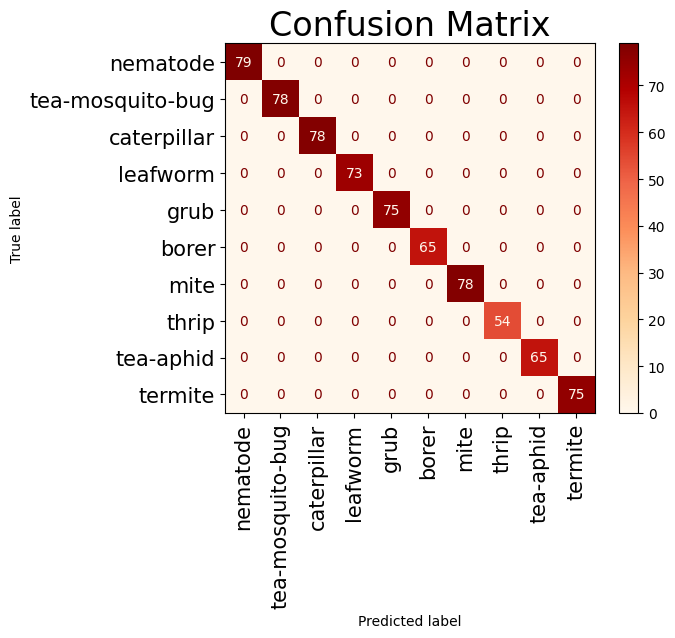

Classification Report:
                   precision    recall  f1-score   support

        nematode       1.00      1.00      1.00        79
tea-mosquito-bug       1.00      1.00      1.00        78
     caterpillar       1.00      1.00      1.00        78
        leafworm       1.00      1.00      1.00        73
            grub       1.00      1.00      1.00        75
           borer       1.00      1.00      1.00        65
            mite       1.00      1.00      1.00        78
           thrip       1.00      1.00      1.00        54
       tea-aphid       1.00      1.00      1.00        65
         termite       1.00      1.00      1.00        75

        accuracy                           1.00       720
       macro avg       1.00      1.00      1.00       720
    weighted avg       1.00      1.00      1.00       720



In [14]:
# Generate class probability predictions on test data
predictions = modelvgg.predict(X_test, verbose=1)

# Convert predicted probabilities to class indices
y_pred = np.argmax(predictions, axis=1)

# Convert one-hot encoded true labels to class indices
y_test = np.argmax(Y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create and display the confusion matrix with class labels
display_cm = ConfusionMatrixDisplay(cm, display_labels=labels)
display_cm.plot(cmap='OrRd', xticks_rotation=90)  # Customize color map and tick rotation

# Adjust font sizes for better readability
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Confusion Matrix', fontsize=24)
plt.show()

# Print detailed classification report (precision, recall, f1-score, support)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=labels))

### 📊 Confusion Matrix & Classification Report

To evaluate how well the model performs across all insect pest classes, we use:

* **Confusion Matrix**: Shows the number of correct vs. incorrect predictions per class.
* **Classification Report**: Provides precision, recall, and F1-score for each class.

### 🧮 Steps Performed:

* The model predicts classes for the test set using `model.predict()`.
* Predictions are converted from probabilities to class indices using `argmax()`.
* True labels are also decoded from one-hot to integer format.
* A confusion matrix is plotted using `ConfusionMatrixDisplay`.
* A full classification report is printed using `classification_report()`.

### 📌 Highlights from Code (not full code):

```python
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_test = np.argmax(Y_test, axis=1)

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()
```

```python
print(classification_report(y_test, y_pred, target_names=labels))
```

### ✅ Output:

* **Confusion Matrix**: Visual heatmap showing class-wise prediction counts.
* **Classification Report**: Precision, recall, F1-score per class with overall accuracy.

This helps identify which insect classes the model confuses most and gives insight into class imbalance or performance issues.

# 📈 14. Multi-Class ROC Curve (One-vs-Rest)

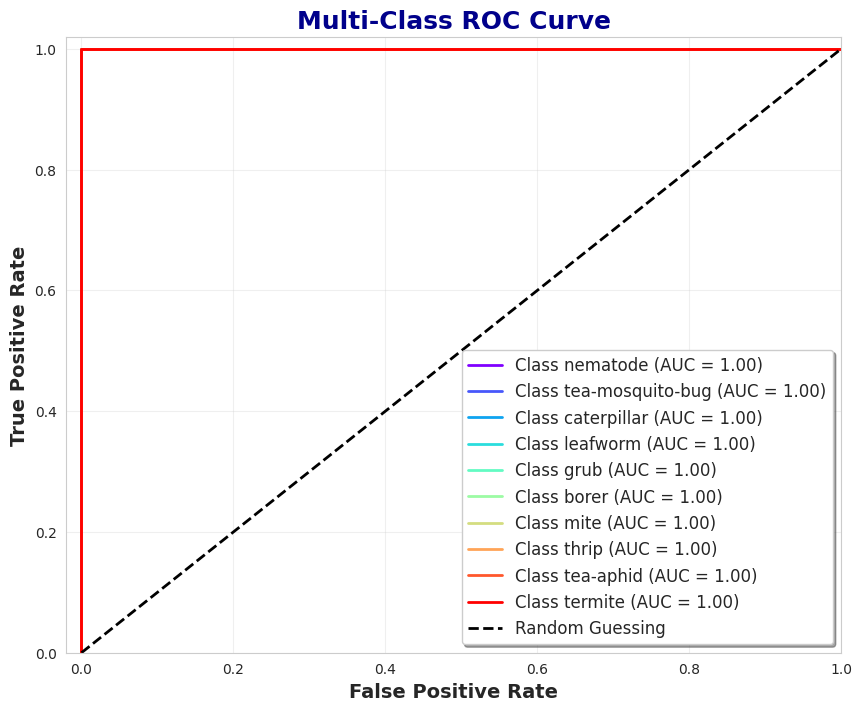

In [15]:
# Get number of classes from one-hot encoded Y_test
n_classes = Y_test.shape[1]

# Initialize dictionaries to store FPR, TPR, and AUC for each class
fpr = {} 
tpr = {}  
roc_auc = {} 

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Set seaborn plotting style
sns.set_style("whitegrid")

# Initialize the ROC plot
plt.figure(figsize=(10, 8))
cmap = get_cmap("rainbow", n_classes)  # Use rainbow colormap for class distinction

# Plot ROC curve for each class
for i in range(n_classes):
    plt.plot(
        fpr[i], tpr[i], color=cmap(i / n_classes), lw=2,
        label=f'Class {labels[i]} (AUC = {roc_auc[i]:.2f})'
    )

# Plot diagonal for random guessing baseline
plt.plot([0, 1], [0, 1], 'k--', lw=2, label="Random Guessing")

# Set axis limits and labels
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.title('Multi-Class ROC Curve', fontsize=18, fontweight='bold', color="darkblue")

# Add legend and grid
plt.legend(loc="lower right", fontsize=12, frameon=True, shadow=True)
plt.grid(alpha=0.3)

# Save and display the ROC curve
plt.savefig("Enhanced_ROC_Curve.png", dpi=600, bbox_inches='tight', transparent=True)
plt.show()

### 🎯 Purpose

The **Receiver Operating Characteristic (ROC)** curve evaluates how well the model distinguishes between classes. It plots **True Positive Rate (TPR)** vs. **False Positive Rate (FPR)** for each class. The **Area Under Curve (AUC)** gives a numerical performance score for each.

### 🧮 Steps Performed:

* Determine the number of classes with `Y_test.shape[1]`
* For each class:

  * Compute `fpr` and `tpr` using `roc_curve()`
  * Calculate `auc` using `auc()`
* Plot all ROC curves using a distinct color map (rainbow)
* Add the baseline diagonal for random performance
* Save the plot as a high-quality `.png` image

### 📌 Highlights from Code (not full code):

```python
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
```

```python
plt.plot(fpr[i], tpr[i], label=f'Class {labels[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
```

```python
plt.savefig("Enhanced_ROC_Curve.png", dpi=600, bbox_inches='tight', transparent=True)
```

### ✅ Output:

* **One-vs-Rest ROC curves** for all insect classes in a single plot
* Each curve is labeled with its class name and AUC score
* **Diagonal baseline** shows random guessing threshold
* **High-resolution saved image** for reporting or presentation use

This helps assess how confidently the model separates each class from the rest, especially useful in multi-class imbalanced datasets.

# 💾 15. Saving the Trained Model

In [16]:
# Save the trained model to an HDF5 file
modelvgg.save("vgg16_classifier.h5")

### 🎯 Purpose

After training and evaluating the model, it’s essential to **persist the model** so that it can be reused for inference or further fine-tuning without retraining from scratch.

### 🧮 Steps Performed:

* Save the entire VGG16-based model using Keras's built-in `save()` method.
* The model is stored in **HDF5 format (`.h5`)**, which includes:

  * Architecture
  * Weights
  * Optimizer state
  * Training configuration

### 📌 Highlight from Code:

```python
modelvgg.save("vgg16_classifier.h5")
```

### ✅ Output:

* The trained model is saved as a file named `vgg16_classifier.h5`.
* This file can later be loaded using:

```python
from tensorflow.keras.models import load_model
model = load_model("vgg16_classifier.h5")
```

This step ensures reproducibility and makes the model deployment-ready.

# 📥 16. Loading the Saved Model

In [17]:
# Load the saved model from the specified path
model = load_model("/kaggle/working/vgg16_classifier.h5")

### 🎯 Purpose

To **reuse a previously trained model** without retraining, we load the saved `.h5` file using Keras.

### 🧮 Steps Performed:

* Use `load_model()` to restore the trained VGG16 classifier.
* This loads:

  * Model architecture
  * Learned weights
  * Training configuration (optimizer, loss, etc.)

### 📌 Highlight from Code:

```python
from tensorflow.keras.models import load_model

model = load_model("/kaggle/working/vgg16_classifier.h5")
```

### ✅ Output:

* The model is successfully loaded and ready for evaluation or prediction.
* You can now perform operations like:

```python
model.evaluate(X_test, Y_test)
model.predict(new_samples)
```

This is useful for deployment, sharing, or continuing training later.

# 🖼️ 17. Visual Prediction on Random Test Images

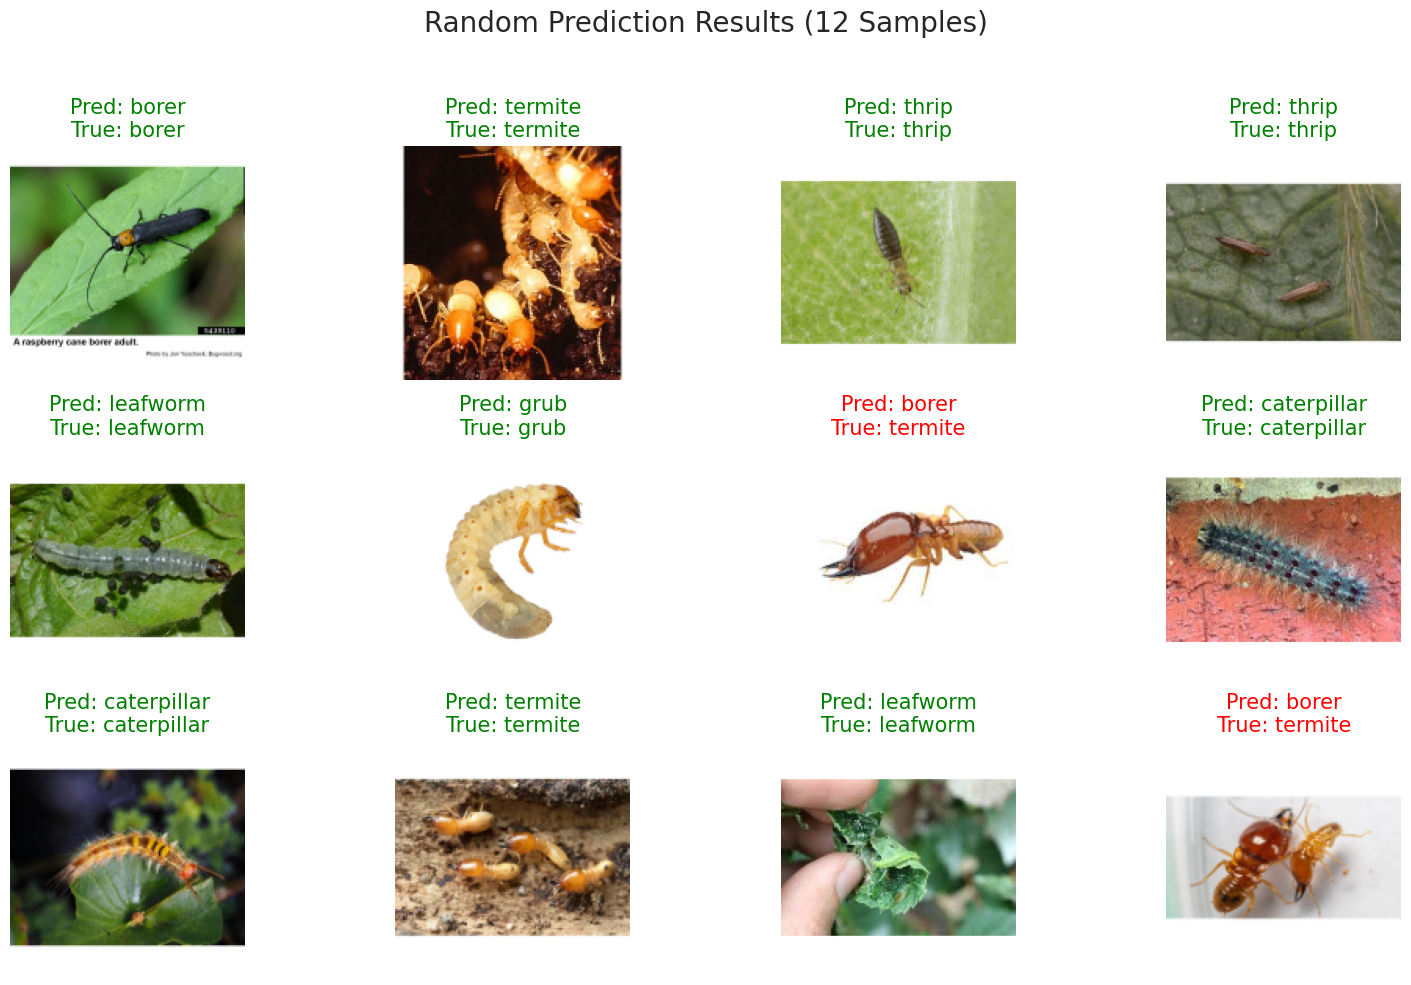

In [18]:
from tensorflow.keras.preprocessing import image

# --- Configuration ---
test_dir = "/kaggle/input/tea-leaves-pest-dataset/TeaLeavesPest-Dataset/pest/test"  # Path to test images
img_size = (150, 150)  # Input size expected by the model
class_names = ['nematode', 'tea-mosquito-bug', 'caterpillar', 'leafworm', 'grub', 
               'borer', 'mite', 'thrip', 'tea-aphid', 'termite']  # Class label list

# --- Collect all test image paths along with their true class labels ---
all_test_images = []
for cls in class_names:
    cls_path = os.path.join(test_dir, cls)  # Path to a specific class folder
    files = os.listdir(cls_path)  # Get all image filenames in this class
    for fname in files:
        all_test_images.append((os.path.join(cls_path, fname), cls))  # Store (image path, label)

# --- Randomly sample 12 images for prediction visualization ---
sampled = random.sample(all_test_images, 12)

# Prepare lists to hold image data, ground truth, and predictions
sample_images = []
true_labels = []
predicted_labels = []

# Process each sampled image
for img_path, true_label in sampled:
    img = image.load_img(img_path, target_size=img_size)  # Load and resize image
    img_array = image.img_to_array(img) / 255.0  # Normalize pixel values
    sample_images.append(img_array)  # Store image array
    true_labels.append(true_label)   # Store true label

    # Predict class using the loaded model
    pred = model.predict(np.expand_dims(img_array, axis=0), verbose=0)
    predicted_labels.append(class_names[np.argmax(pred)])  # Store predicted class label

# --- Display the sampled images with predicted vs true labels ---
plt.figure(figsize=(16, 10))
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(sample_images[i])  # Show the image
    pred_label = predicted_labels[i]
    true_label = true_labels[i]
    color = "green" if pred_label == true_label else "red"  # Green if correct, red if wrong
    ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=15, color=color)
    ax.axis("off")  # Hide axis

# Title and layout adjustment
plt.suptitle("Random Prediction Results (12 Samples)", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()  # Display the complete grid

### 🎯 Purpose

To **visually evaluate** how well the model performs on real test samples by displaying images alongside their predicted and actual class labels.

### 🧮 Steps Performed:

* Define the test dataset directory and class labels.
* Collect all image file paths from the test directory, storing their true class names.
* Randomly sample **12 test images**.
* For each image:

  * Load and preprocess the image.
  * Predict its class using the trained model.
  * Store the prediction and the ground truth.
* Display the images using `matplotlib`, showing:

  * Green title if the prediction is **correct**.
  * Red title if the prediction is **wrong**.

### 📌 Highlight from Code:

```python
img = image.load_img(img_path, target_size=img_size)
img_array = image.img_to_array(img) / 255.0
pred = model.predict(np.expand_dims(img_array, axis=0))
```

```python
plt.imshow(sample_images[i])
plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
```

### ✅ Output:

* A 3×4 grid of **12 test images** is shown.
* Each image shows:

  * Predicted label
  * True label
  * Color-coded title: **green = correct**, **red = incorrect**
* This visual helps quickly assess the model’s real-world accuracy and spot any common misclassifications.

# 🧪 18. Result Visualization

In [19]:
def predict(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0  # Normalize pixel values
    img_expanded = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict using the model
    prediction = model.predict(img_expanded, verbose=0)[0]
    predicted_class = class_names[np.argmax(prediction)]  # Get predicted class name

    # Infer true class from image path
    true_class = None
    for cls in class_names:
        if cls in img_path:
            true_class = cls
            break

    # --- Display image and prediction result ---
    plt.figure(figsize=(10, 4))

    # Left: Display the input image
    plt.subplot(1, 2, 1)
    plt.imshow(img_array)
    plt.title(f"Predicted: {predicted_class}\nTrue: {true_class}", 
              color='green' if predicted_class == true_class else 'red')
    plt.axis('off')

    # Right: Display prediction probabilities as bar chart
    plt.subplot(1, 2, 2)
    sorted_indices = np.argsort(prediction)[::-1]  # Sort by probability
    sorted_probs = prediction[sorted_indices]
    sorted_classes = [class_names[i] for i in sorted_indices]

    bars = plt.barh(range(len(sorted_classes)), sorted_probs, color='skyblue')
    plt.yticks(range(len(sorted_classes)), sorted_classes)
    plt.gca().invert_yaxis()  # Highest probability on top
    plt.title("Class Probabilities")

    bars[0].set_color('orange')  # Highlight predicted class
    plt.tight_layout()
    plt.show()


def predict_random():
    # Pick a random image from the test set
    img_path, true_class = random.choice(all_test_images)

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0
    img_expanded = np.expand_dims(img_array, axis=0)

    # Predict using the model
    prediction = model.predict(img_expanded, verbose=0)[0]
    predicted_class = class_names[np.argmax(prediction)]

    # --- Display image and prediction ---
    plt.figure(figsize=(12, 5))

    # Left: Show image with predicted vs actual label
    plt.subplot(1, 2, 1)
    plt.imshow(img_array)
    plt.title(f"Predicted: {predicted_class}\nTrue: {true_class}",
              color='green' if predicted_class == true_class else 'red')
    plt.axis('off')

    # Right: Show class probability bar chart
    sorted_indices = np.argsort(prediction)[::-1]
    sorted_probs = prediction[sorted_indices]
    sorted_classes = [class_names[i] for i in sorted_indices]

    plt.subplot(1, 2, 2)
    bars = plt.barh(range(len(sorted_classes)), sorted_probs, color='skyblue')
    plt.yticks(range(len(sorted_classes)), sorted_classes)
    plt.xlabel("Probability")
    plt.title("Prediction Probabilities")
    plt.gca().invert_yaxis()
    bars[0].set_color('orange')  # Highlight top prediction

    plt.tight_layout()
    plt.show()

## 🔀 Random Predictions

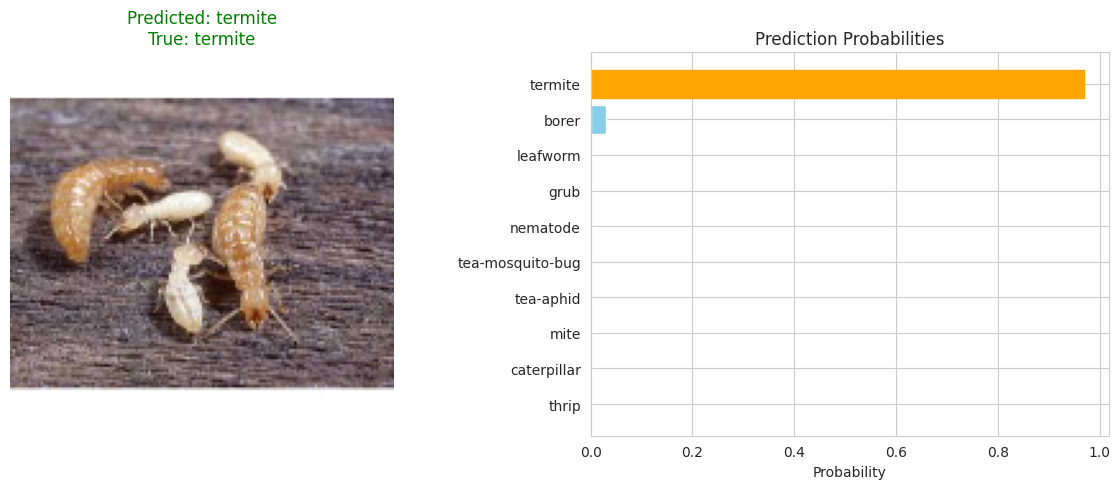

In [20]:
predict_random()

## 🌐 Prediction from Test Directory

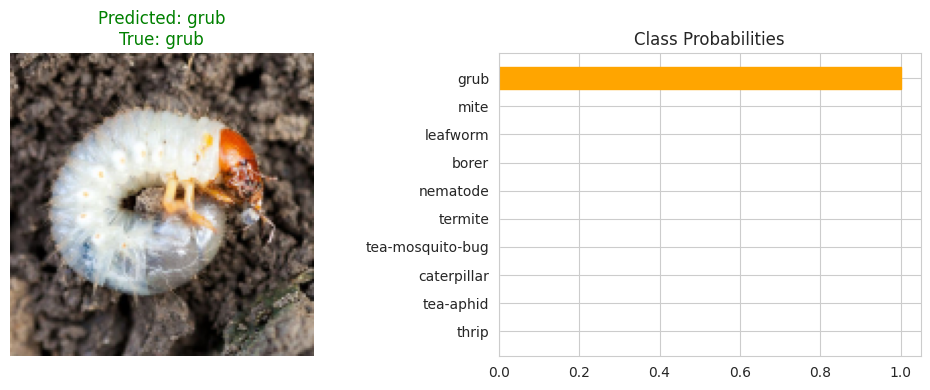

In [21]:
predict("/kaggle/input/tea-leaves-pest-dataset/TeaLeavesPest-Dataset/pest/test/grub/grub_07.jpg")

### 🎯 Purpose

To **analyze model performance** on individual images using two approaches:

* `predict_random()`: test on a randomly chosen image.
* `predict(path)`: test on a specific image path.
* Both visualize the prediction and class probabilities.

### 🔁 `predict_random()`

* Randomly picks an image from the test set.
* Predicts its class using the trained model.
* Displays:

  * **Image** with predicted vs. true label.
  * **Bar chart** showing prediction probabilities for all classes.
* Title is color-coded:

  * ✅ Green = correct prediction
  * ❌ Red = incorrect prediction

✅ **Used for quick visual validation** of the model’s inference on test images.

### 📂 `predict(img_path)`

* Same as `predict_random()`, but on a **specified image path**.
* Useful for **manual inspection** of certain edge cases or failure points.
* Displays:

  * Input image
  * Predicted label vs. actual label
  * Probability chart sorted by confidence

✅ **Good for debugging specific class predictions.**

### ▶️ Example Calls

```python
predict_random()
predict("/kaggle/input/tea-leaves-pest-dataset/TeaLeavesPest-Dataset/pest/test/tea-aphid/tea-aphid_03.jpg")
```

These trigger the above visualizations for:

* A **random** image from the dataset.
* A **specific** test image (in this case, a tea-aphid sample).

### 🧠 Insights Offered

* Helps **visually verify** what the model is confident or confused about.
* Probability bars reveal if the model had **close second guesses**, or was **very certain**.
* Ideal for building interpretability into deep learning results.

Let me know if you'd like this section broken down into subheadings instead.

# 🌐 19. Prediction from Image URL

In [22]:
def predict_from_url(url, model, class_names, img_size=(150, 150)):
    try:
        # Send HTTP request with user-agent header
        headers = {"User-Agent": "Mozilla/5.0"}
        response = requests.get(url, headers=headers, timeout=10)

        # Validate that the URL points to an image
        if 'image' not in response.headers.get("Content-Type", ""):
            raise ValueError("URL did not return an image.")

        # Load image from response and convert to RGB
        img = Image.open(BytesIO(response.content)).convert("RGB")

        # Resize and normalize the image
        img_resized = img.resize(img_size)
        img_array = image.img_to_array(img_resized) / 255.0
        img_array_expanded = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make prediction
        preds = model.predict(img_array_expanded, verbose=0)[0]
        predicted_class = class_names[np.argmax(preds)]

        # --- Display results ---
        plt.figure(figsize=(10, 4))

        # Left: Original image
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_class}")
        plt.axis("off")

        # Right: Prediction probabilities
        plt.subplot(1, 2, 2)
        bars = plt.bar(class_names, preds, color="skyblue")
        bars[np.argmax(preds)].set_color("green")  # Highlight top prediction
        plt.xticks(rotation=45, ha='right', fontsize=9)
        plt.title("Prediction Probabilities")

        plt.tight_layout()
        plt.show()

    except Exception as e:
        # Handle any errors that occur during the process
        print(f"Error loading or processing image from URL:\n{e}")

## ▶️ Example Call

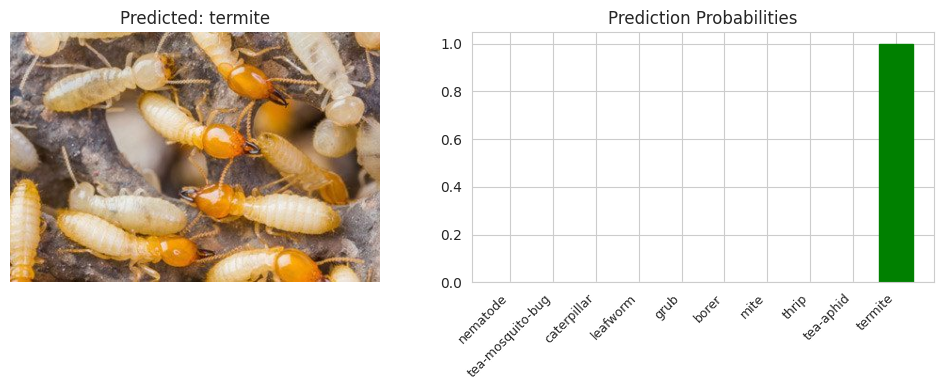

In [23]:
# Define the image URL
url = "https://www.holderspestsolutions.com/wp-content/uploads/2015/11/termites.jpg"

# Call the prediction function using the image URL, preloaded model, and class names
predict_from_url(url, model, class_names)

### 🎯 Purpose

Allows you to **test the trained model on any internet image** via URL — no need to download or manually process the image beforehand.

### 🌍 `predict_from_url(url, model, class_names, img_size=(150, 150))`

* Accepts:

  * A valid image **URL**
  * The trained **model**
  * List of **class\_names**
  * Optional **image size** (default: 150×150)
* Workflow:

  1. Downloads the image using `requests`.
  2. Ensures the content type is a valid image.
  3. Preprocesses it to match training format.
  4. Feeds it to the model for prediction.
  5. Displays:

     * Original image with predicted class
     * Class-wise **probability bar chart**

✅ Useful for **external validation**, real-world examples, or testing on unseen data.


### ⚠️ Error Handling

* If the URL is invalid, non-image, or download fails — prints an error message instead of crashing.
* Ensures robust testing even with uncertain online sources.

Let me know if you want this method integrated with your existing `predict()` and `predict_random()` visualization style.